In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
cd /content/drive/MyDrive/Dataset/

/content/drive/MyDrive/Dataset


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import  mean_squared_error, mean_absolute_error

In [34]:
TRAIN_DIR = 'LSTM-Multivariate_pollution.csv'
TEST_DIR = 'pollution_test_data1.csv'

In [35]:
df_train = pd.read_csv(TRAIN_DIR)

In [36]:
df_train.head(10)

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,1/2/2010 0:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1,1/2/2010 1:00,148,-15,-4.0,1020.0,SE,2.68,0,0
2,1/2/2010 2:00,159,-11,-5.0,1021.0,SE,3.57,0,0
3,1/2/2010 3:00,181,-7,-5.0,1022.0,SE,5.36,1,0
4,1/2/2010 4:00,138,-7,-5.0,1022.0,SE,6.25,2,0
5,1/2/2010 5:00,109,-7,-6.0,1022.0,SE,7.14,3,0
6,1/2/2010 6:00,105,-7,-6.0,1023.0,SE,8.93,4,0
7,1/2/2010 7:00,124,-7,-5.0,1024.0,SE,10.72,0,0
8,1/2/2010 8:00,120,-8,-6.0,1024.0,SE,12.51,0,0
9,1/2/2010 9:00,132,-7,-5.0,1025.0,SE,14.30,0,0


In [37]:
df_train.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  int64  
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 3.0+ MB


In [39]:
df_train.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [40]:
df_train = df_train.drop(columns=["date"])

In [41]:
df_train.shape

(43800, 8)

In [42]:
df_test = pd.read_csv(TEST_DIR)

In [43]:
df_test.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [44]:
df_test.isnull().sum()

dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64

In [45]:
df_test.shape

(346, 8)

***Now We Plot all columns***

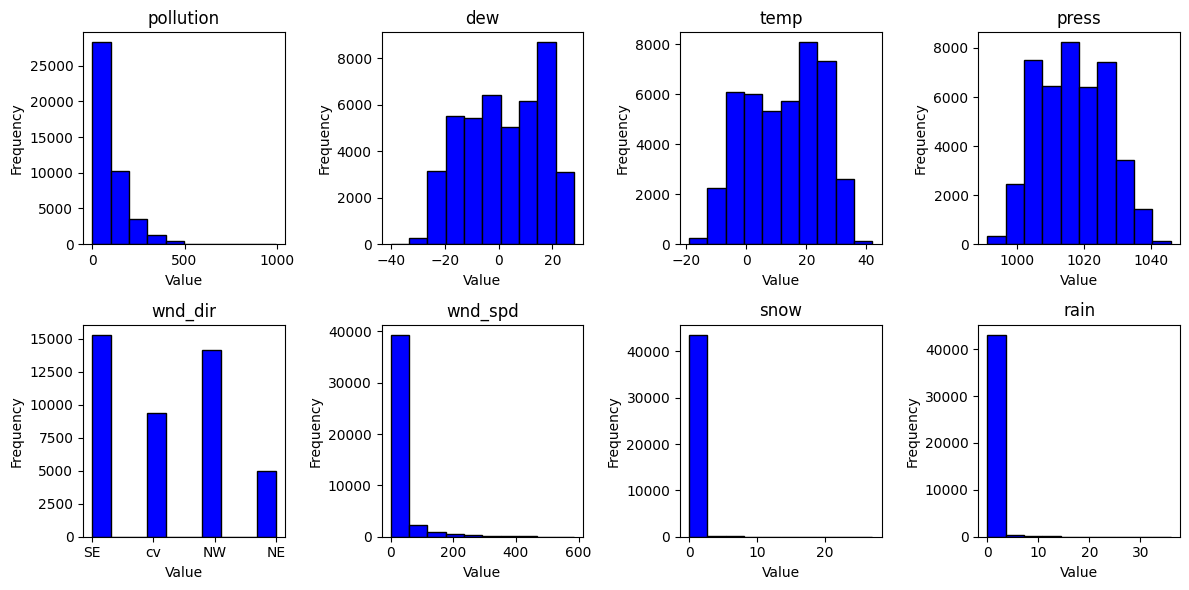

In [46]:
# Creating a histogram for each column
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Flatten the axes to handle them easily
axes = axes.flatten()

for i, column in enumerate(df_train.columns):
    axes[i].hist(df_train[column], bins=10, color='blue', edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

***Preprocessing***

In [47]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# Replace the string values with numerical values
df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

In [48]:
scaler = MinMaxScaler()


# Define the columns to scale
columns = (['pollution', 'dew', 'temp', 'press', 'wnd_spd',
       'snow', 'rain' , "wnd_dir"])


# Scale the selected columns to the range 0-1
df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])


# Show the scaled data
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


***For Training Data***

In [61]:
X_sequences = []
Y_values = []
length = 20

for i in range(len(df_train_scaled) - length):
    X_seq = df_train_scaled.iloc[i : i + length]['pollution'].values
    Y_val = df_train_scaled.iloc[i + length]['pollution']
    X_sequences.append(X_seq)
    Y_values.append(Y_val)

# Convert the lists to NumPy arrays for modeling
X_train = np.array(X_sequences)
y_train = np.array(Y_values)

In [62]:
print(X_train.shape)
print(y_train.shape)

(43780, 20)
(43780,)


***Now the same for Test Data***

In [63]:
X_sequences = []
Y_values = []
length = 20

for i in range(len(df_test_scaled) - length):
    X_seq = df_test_scaled.iloc[i : i + length]['pollution'].values
    Y_val = df_test_scaled.iloc[i + length]['pollution']
    X_sequences.append(X_seq)
    Y_values.append(Y_val)

# Convert the lists to NumPy arrays for modeling
X_test = np.array(X_sequences)
y_test = np.array(Y_values)

In [64]:
print(X_test.shape)
print(y_test.shape)

(326, 20)
(326,)


In [78]:
model=Sequential()
model.add(LSTM(units = 50, return_sequences= True ,input_shape =(length,1)))
model.add(Dropout(.2))
model.add(LSTM(units = 90, return_sequences= True))
model.add(Dropout(.2))
model.add(LSTM(units = 20, return_sequences= True))
model.add(Dropout(.2))
model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(.2))
model.add(LSTM(units = 50))
model.add(Dropout(.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 20, 50)            10400     
                                                                 
 dropout_25 (Dropout)        (None, 20, 50)            0         
                                                                 
 lstm_26 (LSTM)              (None, 20, 90)            50760     
                                                                 
 dropout_26 (Dropout)        (None, 20, 90)            0         
                                                                 
 lstm_27 (LSTM)              (None, 20, 20)            8880      
                                                                 
 dropout_27 (Dropout)        (None, 20, 20)            0         
                                                                 
 lstm_28 (LSTM)              (None, 20, 100)          

In [79]:
callbacks = [
            EarlyStopping(patience = 5, verbose=1),
            ReduceLROnPlateau(monitor='val_accuracy',factor = 0.5, patience = 3, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('model_hd.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

In [80]:
model.compile(optimizer='adam',loss= 'mean_squared_error')

In [81]:
hist = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=10,
    callbacks=callbacks,
    batch_size=32
)

Epoch 1/10
1369/1369 [==============================] - ETA: 0s - loss: 0.0022


Epoch 1: val_loss improved from inf to 0.00086, saving model to model_hd.h5
1369/1369 [==============================] - 157s 105ms/step - loss: 0.0022 - val_loss: 8.5912e-04 - lr: 0.0010
Epoch 2/10
1369/1369 [==============================] - ETA: 0s - loss: 0.0011


Epoch 2: val_loss improved from 0.00086 to 0.00076, saving model to model_hd.h5
1369/1369 [==============================] - 139s 101ms/step - loss: 0.0011 - val_loss: 7.6026e-04 - lr: 0.0010
Epoch 3/10
1369/1369 [==============================] - ETA: 0s - loss: 9.7256e-04


Epoch 3: val_loss did not improve from 0.00076
1369/1369 [==============================] - 138s 101ms/step - loss: 9.7256e-04 - val_loss: 8.5302e-04 - lr: 0.0010
Epoch 4/10
1369/1369 [==============================] - ETA: 0s - loss: 9.7213e-04


Epoch 4: val_loss did not improve from 0.00076
1369/1369 [==============================] - 137s 100ms/step - loss: 9.7213e-04 - val_loss: 8.3076e-04 - lr: 0.0010
Epoch 5/10
1369/1369 [==============================] - ETA: 0s - loss: 9.3371e-04


Epoch 5: val_loss did not improve from 0.00076
1369/1369 [==============================] - 138s 101ms/step - loss: 9.3371e-04 - val_loss: 9.3303e-04 - lr: 0.0010
Epoch 6/10
1369/1369 [==============================] - ETA: 0s - loss: 9.0884e-04


Epoch 6: val_loss did not improve from 0.00076
1369/1369 [==============================] - 135s 98ms/step - loss: 9.0884e-04 - val_loss: 7.6782e-04 - lr: 0.0010
Epoch 7/10
1369/1369 [==============================] - ETA: 0s - loss: 8.9149e-04


Epoch 7: val_loss improved from 0.00076 to 0.00072, saving model to model_hd.h5
1369/1369 [==============================] - 135s 98ms/step - loss: 8.9149e-04 - val_loss: 7.2000e-04 - lr: 0.0010
Epoch 8/10
1369/1369 [==============================] - ETA: 0s - loss: 8.8635e-04


Epoch 8: val_loss did not improve from 0.00072
1369/1369 [==============================] - 135s 99ms/step - loss: 8.8635e-04 - val_loss: 7.3203e-04 - lr: 0.0010
Epoch 9/10
1369/1369 [==============================] - ETA: 0s - loss: 8.5649e-04


Epoch 9: val_loss did not improve from 0.00072
1369/1369 [==============================] - 136s 99ms/step - loss: 8.5649e-04 - val_loss: 8.0625e-04 - lr: 0.0010
Epoch 10/10
1369/1369 [==============================] - ETA: 0s - loss: 8.6100e-04


Epoch 10: val_loss did not improve from 0.00072
1369/1369 [==============================] - 138s 101ms/step - loss: 8.6100e-04 - val_loss: 7.2619e-04 - lr: 0.0010


In [82]:
pred=model.predict(X_test)
test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=pred.flatten()
print(test)

11/11 [==============================] - 4s 29ms/step
         test      pred
0    0.124748  0.139095
1    0.135815  0.126569
2    0.132797  0.139085
3    0.133803  0.134614
4    0.142857  0.135831
..        ...       ...
321  0.008048  0.017144
322  0.010060  0.015567
323  0.010060  0.017170
324  0.008048  0.017115
325  0.012072  0.015600

[326 rows x 2 columns]


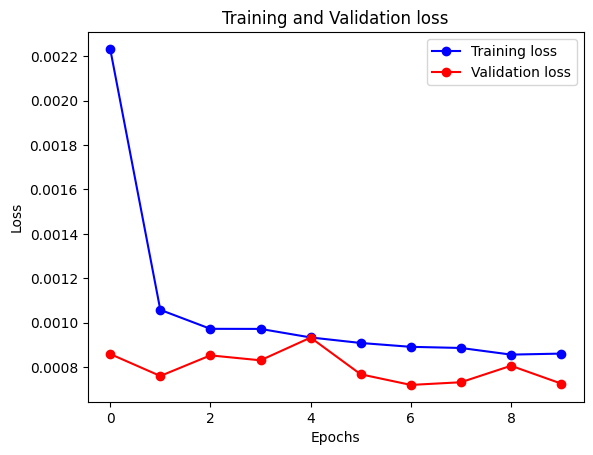

In [83]:
plt.plot(hist.history['loss'], 'b-o', label='Training loss')
plt.plot( hist.history['val_loss'], 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

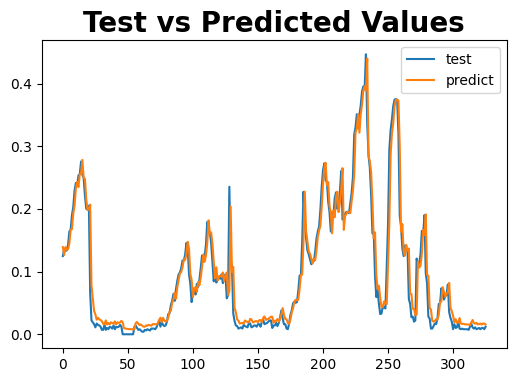

In [84]:
fig=plt.figure(figsize=(6,4))
plt.title("Test vs Predicted Values",size=20, weight='bold')
plt.plot(test)
plt.legend(['test','predict'])

In [85]:
hist.history

{'loss': [0.0022326349280774593,
  0.0010579965310171247,
  0.0009725629934109747,
  0.0009721311507746577,
  0.0009337107767350972,
  0.0009088355000130832,
  0.0008914917707443237,
  0.0008863504626788199,
  0.0008564856834709644,
  0.000861004984471947],
 'val_loss': [0.0008591152145527303,
  0.0007602620753459632,
  0.0008530209306627512,
  0.0008307649404741824,
  0.000933028815779835,
  0.000767817604355514,
  0.0007200014078989625,
  0.000732030370272696,
  0.0008062534034252167,
  0.0007261920836754143],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}